<a href="https://colab.research.google.com/github/casperbh96/mbml/blob/master/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the packages

In [46]:
# Install Pyro, if necessary
!pip install pyro-ppl

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import copy
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

pd.set_option('display.max_columns', 50)
%matplotlib inline

# Loading the dataset

This is the Santander Product Recommendation dataset from [Kaggle](https://www.kaggle.com/c/santander-product-recommendation/data).

In [48]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
#train_path = 'data/train_ver2.csv'
train_path = '/content/gdrive/My Drive/MSc: AI/2. semester/MBML/train_ver2.csv'
#train_path = '/content/gdrive/My Drive/DTU/Model-based machined learning/project/data/train_ver2.csv'

train_df = pd.read_csv(train_path, parse_dates=['fecha_dato', 'fecha_alta', 'ult_fec_cli_1t'], sep=",",na_values = ['?', 'NA'])

train_df.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaT,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaT,1,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [51]:
#test_path = 'data/test_ver2.csv'
test_path = '/content/gdrive/My Drive/MSc: AI/2. semester/MBML/test_ver2.csv'
#test_path = '/content/gdrive/My Drive/DTU/Model-based machined learning/project/data/test_ver2.csv'

test_df = pd.read_csv(test_path, parse_dates=['fecha_dato', 'fecha_alta', 'ult_fec_cli_1t'],
                      sep=",",na_values = ['?', 'NA'], nrows = 50000)

test_df.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,NaT,1.0,A,S,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,ES,H,36,2013-08-28,0,34,1,NaT,1.0,I,S,N,NaN,KAT,N,1,3.0,ALICANTE,0,NA,02 - PARTICULARES
2,2016-06-28,1170545,N,ES,V,22,2013-08-28,0,34,1,NaT,1.0,A,S,N,NaN,KHE,N,1,15.0,"CORUÑA, A",1,NA,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,ES,H,22,2013-08-28,0,34,1,NaT,1.0,I,S,N,NaN,KHE,N,1,8.0,BARCELONA,0,148402.98,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,ES,H,22,2013-08-28,0,34,1,NaT,1.0,I,S,N,NaN,KHE,N,1,7.0,"BALEARS, ILLES",0,106885.80,03 - UNIVERSITARIO


In [0]:
print(train_df.shape)
print(test_df.shape)

(13647309, 48)
(50000, 24)


In [0]:
columns_num = ['age',
               'renta',
               'antiguedad',
               'ncodpers']

columns_cat = ['ind_empleado',
               'pais_residencia',   
               'sexo',
               'ind_nuevo',
               'indrel',                    
               'tiprel_1mes', 
               'indresi',
               'indrel_1mes',
               'indext',
               'canal_entrada',     #The encoding creates too much columns, not very relevant (the weights are low)
               'conyuemp',           #100% of NaN values (see below)
               'indfall',
               'nomprov',
               'segmento',
               'tipodom',
               'cod_prov',
               'ind_actividad_cliente']

columns_date =['fecha_dato',
               'fecha_alta',
               'ult_fec_cli_1t']    #100% of NaN values (see below)

# Descriptive Statistics & Visualization

In [0]:
print("age value statistics", train_df['age'].describe())
print("\n \n \n renta value statistics \n\n", train_df['renta'].describe())

print("\n\n\n categorical value statistics \n\n", train_df[columns_cat].describe())
print("\n\n\n date value statistics \n\n", train_df[columns_date].describe())

age value statistics count     500000
unique       115
top           23
freq       39228
Name: age, dtype: object

 
 
 renta value statistics 

 count    4.110990e+05
mean     1.318600e+05
std      2.293840e+05
min      1.202730e+03
25%      6.748633e+04
50%      9.982623e+04
75%      1.531584e+05
max      2.889440e+07
Name: renta, dtype: float64



 categorical value statistics 

            ncodpers         indrel      ind_nuevo    indrel_1mes   tipodom  \
count  5.000000e+05  494611.000000  494611.000000  494611.000000  494611.0   
mean   8.171304e+05       1.130769       0.000303       1.000091       1.0   
std    4.381616e+05       3.577475       0.017412       0.013414       0.0   
min    1.588900e+04       1.000000       0.000000       1.000000       1.0   
25%    3.362618e+05       1.000000       0.000000       1.000000       1.0   
50%    9.856585e+05       1.000000       0.000000       1.000000       1.0   
75%    1.177883e+06       1.000000       0.000000       1.000000    

In [0]:
def plot_dates(datetimes, title):
    # Size of figure
    plt.figure(figsize=(15,8))

    # Plot the values
    sns.barplot(
        datetimes.index, 
        datetimes.values,
        alpha=0.7,
        color=(0, 0, 0.9)
    )

    # Make labels x: yyyymm format
    plt.xlabel('Year and month ', fontsize=16)
    plt.ylabel('Number of customers on date', fontsize=16)

    # Make xlabel vertical instead of horizontal
    plt.xticks(rotation='vertical')
    
    plt.suptitle(title, fontsize=24)

    plt.show()

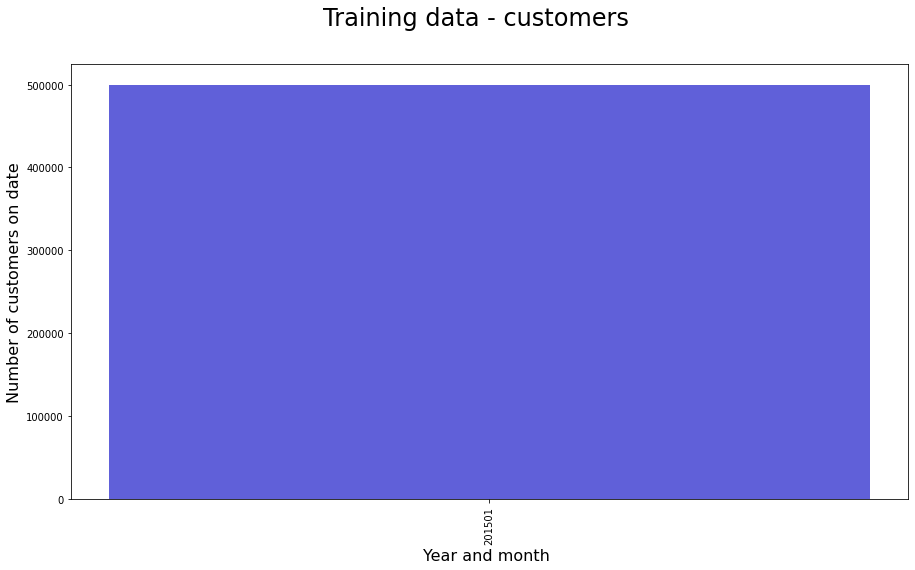

In [0]:
yearmonth = train_df['fecha_dato'].apply(
    lambda x: (100*x.year) + x.month
).value_counts()

plot_dates(yearmonth, 'Training data - customers')

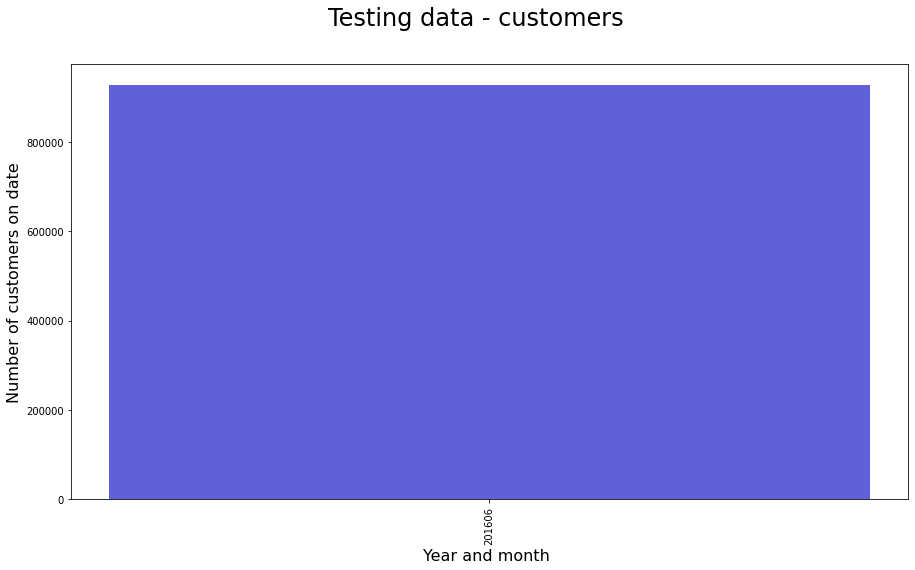

In [0]:
test_yearmonth = test_df['fecha_dato'].apply(
    lambda x: (100*x.year) + x.month
).value_counts()

plot_dates(test_yearmonth, 'Testing data - customers')

# Cleaning the dataset

In [0]:
print("Training NaN values percentages \n\n",(train_df.isna().sum()/train_df.shape[0])*100)
print("\n\n Testing NaN values percentages \n\n",(test_df.isna().sum()/test_df.shape[0])*100)

Training NaN values percentages 

 fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.203220
pais_residencia           0.203220
sexo                      0.203732
age                       0.000000
fecha_alta                0.203220
ind_nuevo                 0.203220
antiguedad                0.000000
indrel                    0.203220
ult_fec_cli_1t           99.818330
indrel_1mes               1.097513
tiprel_1mes               1.097513
indresi                   0.203220
indext                    0.203220
conyuemp                 99.986752
canal_entrada             1.363829
indfall                   0.203220
tipodom                   0.203227
cod_prov                  0.685784
nomprov                   0.685784
ind_actividad_cliente     0.203220
renta                    20.475648
segmento                  1.387585
ind_ahor_fin_ult1         0.000000
ind_aval_fin_ult1         0.000000
ind_cco_fin_ult1          0.000000
ind_cder_fin_ult1   

In [0]:
def nan_value_check(value):
    check = str(val).replace(' ', '').lower()
    if check == '?' or check == 'na' or check == 'nan':
        return True
    else:
        return False

## Removing the obvious features

We can clearly see that 'ult_fec_cli_1t' and 'conyuemp' should be removed, because they have almost 100% NaN values, which we cannot use for anything.

In [0]:
# remove columns with too many NaN values
drop_features = ['ult_fec_cli_1t', 'conyuemp']
#nomprov and cod_prov are the same information, and the encoding creates too many columns
drop_features.append('nomprov')
drop_features.append('cod_prov')
#tipodom has only one value
drop_features.append('tipodom')
#the encoding of canal_entrada and pais_residencia creates too many columns
drop_features.append('canal_entrada')
drop_features.append('pais_residencia')

In [0]:
train_df = train_df.drop(drop_features, axis=1)
test_df = test_df.drop(drop_features, axis=1)

In [0]:
columns_date.remove(drop_features[0])
columns_cat.remove(drop_features[1])
columns_cat.remove(drop_features[2])
columns_cat.remove(drop_features[3])
columns_cat.remove(drop_features[4])
columns_cat.remove(drop_features[5])
columns_cat.remove(drop_features[6])

## The feature 'renta'

This feature has nan values, but not enough to where we want to drop it. Instead, we choose to prepare it for imputation.

In [0]:
# make nan values into numpy nan values
train_df['renta'] = train_df['renta'].fillna(np.nan)

# test data is type object
new_vals = []
for val in test_df['renta']:
    if nan_value_check(val):
        val = np.nan
    new_vals.append(val)
    
test_df['renta'] = np.array(new_vals, dtype=float)

###test_df['renta'] = test_df['renta'].fillna(np.nan) why not only this line ?

We have chosen to impute the values for renta, since the feature could potentially have good predictive power, in terms of which products a customer might want to purchase.

In [58]:
print("Number of Nan values in column renta before the process:")
print(train_df['renta'].isna().sum())
print(test_df['renta'].isna().sum())

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
train_df['renta'] = imputer.fit_transform(train_df['renta'].values.reshape(-1, 1))

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
test_df['renta'] = imputer.fit_transform(test_df['renta'].values.reshape(-1, 1))

print("\nAfter the imputation:")
print(train_df['renta'].isna().sum())
print(test_df['renta'].isna().sum())

Number of Nan values in column renta before the process:
2794375
9779

After the imputation:
0
0


## The rest of the data

We choose to drop the rest of the rows that contains NaN values, since it represents a low percentage.

In [0]:
train_df['age'] = train_df['age'].str.strip()
train_df['antiguedad'] = train_df['antiguedad'].str.strip()

In [0]:
train_df = train_df.dropna(axis=0, how='any')
test_df = test_df.dropna(axis=0, how='any')

In [0]:
train_df['age'] = train_df['age'].astype(np.float64)
train_df['antiguedad'] = train_df['antiguedad'].astype(np.float64)
test_df['age'] = test_df['age'].astype(np.float64)
test_df['antiguedad'] = test_df['antiguedad'].astype(np.float64)

## The feature "indrel_1mes"

This feature can take only 5 different values, but actually, we can more types because some of the numbers are "float" while others are "string".


In [0]:
new_vals = []
for val in test_df["indrel_1mes"]:
  if type(val)=='str':
    val = float(val)
  new_vals.append(val)
test_df["indrel_1mes"] = np.array(new_vals, dtype=float)

new_vals = []
for val in train_df["indrel_1mes"]:
  if type(val)=='str':
    val = float(val)
  new_vals.append(val)
train_df["indrel_1mes"] = np.array(new_vals, dtype=float)

## A quick check on the total number of NaN values

In [0]:
train_nan_values = 0
test_nan_values = 0

for name, values in train_df.iteritems():
    for val in values:
        if nan_value_check(val):
            train_nan_values += 1

for name, values in test_df.iteritems():
    for val in values:
        if nan_value_check(val):
            test_nan_values += 1
            
print(f'There are {train_nan_values} NaN values in training dataset')
print(f'There are {test_nan_values} NaN values in testing dataset')

There are 0 NaN values in training dataset
There are 0 NaN values in testing dataset


# Preparing X and Y values

In this section, we want to prepare our inputs and outputs of the model. In particular, we want to include the prior information of which products the customer is already paying for.

In [80]:
y_variables = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
       'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1']

print(train_df.shape)

(3756556, 41)


In [81]:
#Need to change this later, and to take into account all the features
X_cat = np.concatenate([pd.get_dummies(train_df[x]) for x in columns_cat], axis=1)
#We don't need the codpers to make predictions based on the profile
X_num = train_df[columns_num[:-1]]
X = np.concatenate([X_cat, X_num], axis=1)

mat = train_df[y_variables].values
Y = mat[:].astype("int")
print(X.shape)
print(Y.shape)

(3756556, 30)
(3756556, 24)


In [0]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [0]:
filter = []
for i in range(Y.shape[0]):
  filter.append(sum(Y[i]) == 1)

X = X[filter]
Y = Y[filter]

## Encoding the dataset

To be able to use our dataset, we must encode all features, so that they appear as numbers instead of strings, datetimes, or other datatypes.

### Columns of type 'object'

In [0]:
X_cat = np.concatenate([pd.get_dummies(X_train[x]) for x in columns_cat], axis=1)
#print(X_cat.shape)

In [68]:
totaltrain = 0
totaltest = 0
for column in columns_cat:

  train_cat_encoded = pd.get_dummies(X_train[column])
  test_cat_encoded = pd.get_dummies(X_test[column])
  L = []
  J = []
  #print("___")
  totaltrain += train_cat_encoded.shape[1]
  totaltest += test_cat_encoded.shape[1]
  print(column)
  print(train_cat_encoded.shape[1])
  print(test_cat_encoded.shape[1])
print(totaltrain)
print(totaltest)

IndexError: ignored

In [69]:
X_train = X_train.drop(columns_cat, axis=1)
X_test = X_test.drop(columns_cat, axis=1)

AttributeError: ignored

Here, there is a problam because the number of columns in test_cat_encoded is bigger than the numberof clums in train_cat_encoded, but it's important that our two dataset have the same number of columns

In [0]:
X_train = pd.concat([X_train, train_cat_encoded], axis=1)
X_test = pd.concat([X_test, test_cat_encoded], axis=1)

### Columns of type 'datetime64'

In [0]:
def datetime_to_features(timestamp):
    year = timestamp.year
    month = timestamp.month
    day = timestamp.day
    
    return year, month, day

In [0]:
def datetimes_to_features(dt_features):
    data = pd.DataFrame()
    for name, values in dt_features.iteritems():
        year = []
        month = []
        day = []

        for val in values:
            y,m,d = datetime_to_features(val)
            year.append(y) ; month.append(m) ; day.append(d)

        new_features = {name + '_year'  : year,
                        name + '_month' : month,
                        name + '_day'   : day}
        
        new_data = pd.DataFrame(new_features)
        data = pd.concat([data, new_data], axis=1)
        
    return data

In [72]:
train_new_features = datetimes_to_features(X_train[columns_date])
test_new_features = datetimes_to_features(X_test[columns_date])

TypeError: ignored

In [73]:
X_train = X_train.drop(columns_date, axis=1)
X_test = X_test.drop(columns_date, axis=1)

AttributeError: ignored

In [0]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train = pd.concat([X_train, train_new_features], axis=1)
X_test = pd.concat([X_test, test_new_features], axis=1)

### Checking Column Equality

In [0]:
not_in_test = []
for col in X_train.columns:
    if col not in X_test.columns and col not in y_variables:
        not_in_test.append(col)
        
print(not_in_test)

[]


In [0]:
X_train = X_train.drop(not_in_test, axis=1)

In [0]:
print(X_train.shape)
print(y_train.shape)

(982056, 36)
(982056, 24)


In [0]:
X_train.head(5)

,ncodpers,age,antiguedad,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,0.0,1.0,fecha_dato_year,fecha_dato_month,fecha_dato_day,fecha_alta_year,fecha_alta_month,fecha_alta_day
0,1375586,35.0,6.0,87218.10000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,1,28,2015,1,12
1,1050611,23.0,35.0,35548.74000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0,2015,1,28,2012,8,10
2,1050612,23.0,35.0,122179.11000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0,2015,1,28,2012,8,10
3,1050613,22.0,35.0,119775.54000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0,2015,1,28,2012,8,10
4,1050614,23.0,35.0,139646.15094,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,1,28,2012,8,10


### Baseline

In [0]:
ncodpers = X_test['ncodpers'].values

pred_df = pd.DataFrame({'ncodpers':ncodpers, 'added_products': predictions})
pred_df.to_csv('data/predictions.csv', columns=pred_df.columns)

#Functions to assess the accuracy of the model

For the general accuracy:

In [0]:
def accuracy(y_hat, y_test):
  return 1.0*np.sum(y_hat == y_test) / len(y_test)

Then, we check the number of times where a customer has bought a product, and if this product has been predicted by the model

In [0]:
def accuracy_2(y_hat, y_test):
  correct = 0
  for i in range(len(y_test)):
    if y_test[i] == 1:
      correct += y_hat[i]

  if sum(y_test) > 0:
    return 1.0*correct/sum(y_test)
  else:
    return "This product has never been bought by the customers, and has been predicted \"bought\" " + str(sum(y_hat)) + " times by the model"

Finally, we count the number of times where we have predicted something, and this prediction was correct

In [0]:
def accuracy_model(y_hat, y_test):
  correct = 0
  for i in range(len(y_hat)):
    if y_hat[i] == 1:
      correct += y_test[i]
      
  if sum(y_hat) > 0:
    return 1.0*correct/sum(y_hat)
  else:
    return "This product has never been predicted as bought by the model, and has been bought " + str(sum(y_test)) + " times by the customers"

This function will compute the accuracy of a full line of predictions:

In [0]:
def accuracy_full_line(y_hat, y_test):
  correct = 0
  nb_products = len(y_hat[1])
  for i in range(len(y_hat)):
    test = 0
    for j in range(nb_products):
      test += (y_hat[i][j] == y_test[i][j])
    if test == nb_products:
      correct += 1
  return correct/len(y_test)

Thess functions return the accuracy of the predictions by products for each line

In [0]:
def accuracy_by_product(y_hat, y_test):
  E = []
  for i in range(len(y_hat[1])):
    E.append(accuracy(y_hat[:,i],y_test[:,i]))
  return E

def accuracy_2_by_product(y_hat, y_test):
  E = []
  for i in range(len(y_hat[1])):
    E.append(accuracy_2(y_hat[:,i],y_test[:,i]))
  return E

def accuracy_model_by_product(y_hat, y_test):
  E = []
  for i in range(len(y_hat[1])):
    E.append(accuracy_model(y_hat[:,i],y_test[:,i]))
  return E

#Baseline

In [0]:
#Need to change this later, and to take into account all the features
X_cat = np.concatenate([pd.get_dummies(train_df[x]) for x in columns_cat], axis=1)
#We don't need the codpers to make predictions based on the profile
X_num = train_df[columns_num[:-1]]
X = np.concatenate([X_cat, X_num], axis=1)
print(X.shape)


(989027, 30)


In [0]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

###For only one product: (product number 7)
For this first example, we just try to predict for one product, and the prediction is based on the features in "columns_cat"

In [0]:
mat = train_df[y_variables].values
Y = mat[:,7].astype("int")
print(X.shape)
print(Y.shape)
print("number of 1 values :", sum(Y))

(989027, 30)
(989027,)
number of 1 values : 211687


In [0]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y[ix_train]
Y_test = Y[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 741770
num test: 247257


In [0]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter = 5000)
logreg.fit(X_train, Y_train)

# make predictions for test set
Y_hat = logreg.predict(X_test)
print("predictions:", Y_hat)
print("true values:", Y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(Y_hat == Y_test) / len(Y_test))

predictions: [0 0 0 ... 0 1 0]
true values: [0 0 0 ... 0 1 0]
Accuracy: 0.7674848437051327


In [0]:
print(sum(Y_hat))
print(sum(Y_test))

29559
52930


###For all the products:

In [0]:
mat = train_df[y_variables].values
Y = mat[:].astype("int")
print(X.shape)
print(Y.shape)

(989027, 30)
(989027, 24)


In [0]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y[ix_train]
Y_test = Y[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 741770
num test: 247257


In [0]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
Y_hat = dtc.predict(X_test)

In [0]:
print(accuracy_full_line(Y_hat, Y_test))
print(accuracy_by_product(Y_hat, Y_test))
print(accuracy_2_by_product(Y_hat, Y_test))
print(accuracy_model_by_product(Y_hat, Y_test))

0.7257347618065414
[0.9999555118763068, 0.9999919112502376, 0.8799750866507319, 0.9996360062606923, 0.9379107568238715, 0.9996926275090291, 0.9901115034154746, 0.9348248987895186, 0.9688866240389554, 0.9974722656992522, 0.9978888363120154, 0.9660636503718802, 0.9405032011227185, 0.9845262217045423, 0.9945198720359788, 0.9918182296153395, 0.9975086650731829, 0.9613519536352864, 0.9542500313439053, 0.9787872537481245, 0.9963074857334676, 0.949323982738608, 0.9447983272465491, 0.9021827491233817]
[0.7692307692307693, 0.875, 0.9187685738501646, 0.5918367346938775, 0.6928834682168775, 0.9884921805842432, 0.4924, 0.8385700846660396, 0.7730133752950433, 0.4377431906614786, 0.6582597730138714, 0.734344894026975, 0.7101222903729666, 0.7051739518287243, 0.7023519870235199, 0.7041678016889131, 0.6691449814126395, 0.7148928737773638, 0.6344112115512953, 0.7144740845927579, 0.7064555420219245, 0.6275310437409106, 0.6364461018999144, 0.6905862144049548]
[0.9375, 1.0, 0.9217798922549499, 0.7435897435

#And now we will use Pyro. First model: predictions for one product based on the profile of the customers

First we use Pyro for one product

In [0]:
#Need to change this later, and to take into account all the features
X_cat = np.concatenate([pd.get_dummies(train_df[x]) for x in columns_cat], axis=1)
#We don't need the codpers to make predictions based on the profile
X_num = train_df[columns_num[:-1]]
X = np.concatenate([X_cat, X_num], axis=1)
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [79]:
mat = train_df[y_variables].values
Y = mat[:].astype("int")
print(X.shape)
print(Y.shape)

(2321568, 30)
(3756556, 24)


In [84]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y[ix_train]
Y_test = Y[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 1741176
num test: 580392


In [0]:
def first_model(X, obs=None):
    input_dim = X.shape[1]
    n_cat = 2

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 5.*torch.ones(1, n_cat)))  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 5.*torch.ones(input_dim, n_cat))) # Priors for the regression coeffcients
    
    
    with pyro.plate("data"):
      y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [0]:
%%time

# Define guide function
guide = AutoDiagonalNormal(first_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 5000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(first_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, Y_train[:,7])
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 11154163.3
[500] ELBO: 5413570.1
[1000] ELBO: 1818106.2
[1500] ELBO: 1109255.5
[2000] ELBO: 1031153.9
[2500] ELBO: 996176.1
[3000] ELBO: 977484.0
[3500] ELBO: 961824.8
[4000] ELBO: 952058.8
[4500] ELBO: 953506.7
CPU times: user 1h 4min 22s, sys: 20.5 s, total: 1h 4min 43s
Wall time: 31min 4s


Once converged, let's extract the posterior samples for the latent variables in the model using Pyro's Predictive class:

In [0]:
from pyro.infer import Predictive

predictive = Predictive(first_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha"))
samples = predictive(X_train, Y_train)

Lets plot the posterior distributions of the parameters:

In [0]:
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
print(beta_samples.shape)
print(alpha_samples.shape)

(2000, 82, 2)
(2000, 1, 2)


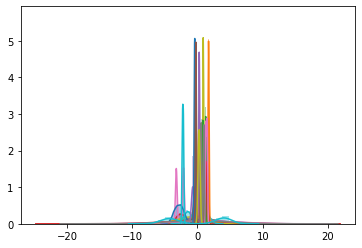

In [0]:
#attempt to plot the beta, not very successful, there are too much beta
for c in range(beta_samples.shape[1]):
    sns.distplot(beta_samples[:,c])
#plt.legend(["beta[%d]" % c for c in range(119)])
plt.show()

We can now use the inferred posteriors to make predictions:

In [0]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [0]:
# make predictions for test set
Y_hat = alpha_hat + np.dot(X_test, beta_hat)
Y_hat = np.argmax(Y_hat, axis=1)

print(accuracy(Y_hat, Y_test[:,7]))
print(accuracy_2(Y_hat, Y_test[:,7]))
print(accuracy_model(Y_hat, Y_test[:,7]))

0.7870110856315493
0.03697102988017594
0.5106048703849175


In [0]:
# make predictions for test set with all the lines
Y_hat = alpha_hat + np.dot(X_test, beta_hat)
Y_hat = np.argmax(Y_hat, axis=1)

print(accuracy(Y_hat, Y_test[:,7]))
print(accuracy_2(Y_hat, Y_test[:,7]))
print(accuracy_model(Y_hat, Y_test[:,7]))

0.8334985555918772
0.06615119733099564
0.5583710407239819


#Second model: predictions for all the products based on the profile of the customers

In [0]:
#Need to change this later, and to take into account all the features
X_cat = np.concatenate([pd.get_dummies(train_df[x]) for x in columns_cat], axis=1)
#We don't need the codpers to make predictions based on the profile
X_num = train_df[columns_num[:-1]]
X = np.concatenate([X_cat, X_num], axis=1)
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [0]:
mat = train_df[y_variables].values
Y = mat[:].astype("int")
print(X.shape)
print(Y.shape)


(989027, 30)
(989027, 24)


In [0]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y[ix_train]
Y_test = Y[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 741770
num test: 247257


In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train[:2000,:]).float()
Y_train = torch.tensor(Y_train[:2000,:]).float()

In [0]:
def categorical_model(X, obs=None):
    input_dim = X.shape[1]
    n_cat = obs.shape[1]

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 5.*torch.ones(1, n_cat)))
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 5.*torch.ones(input_dim, n_cat)))

    with pyro.plate("data"):     
        y = pyro.sample("y", dist.OneHotCategorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [0]:
%%time

# Define guide function
guide = AutoDiagonalNormal(categorical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 6000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(categorical_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, Y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 27839.5
[500] ELBO: 5041.9
[1000] ELBO: 4310.7
[1500] ELBO: 3995.4
[2000] ELBO: 3820.1
[2500] ELBO: 4008.2
[3000] ELBO: 3731.1
[3500] ELBO: 3724.6
[4000] ELBO: 3805.8
[4500] ELBO: 3694.3
[5000] ELBO: 3711.1
[5500] ELBO: 3719.7
CPU times: user 2min 23s, sys: 746 ms, total: 2min 24s
Wall time: 48.3 s


In [0]:
from pyro.infer import Predictive

predictive = Predictive(categorical_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha"))

samples = predictive(X_train, Y_train)

beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
print(beta_samples.shape)
print(alpha_samples.shape)

# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

torch.Size([2000, 30])
torch.Size([2000, 24])
(2000, 30, 24)
(2000, 1, 24)


In [0]:
# make predictions for test set
Y_hat = alpha_hat + np.dot(X_test, beta_hat)

#rebuild matrix
Y_hat_arg=np.argmax(Y_hat,axis=1)
Y_hat_pred=np.zeros((Y_hat.shape[0],Y_hat.shape[1]))
for i in range(Y_hat.shape[0]): 
    Y_hat_pred[i,Y_hat_arg[i]]=1



# evaluate prediction accuracy
print("Accuracy:",accuracy_full_line(Y_hat_pred, Y_test))
print(sum(Y_hat))

Accuracy: 0.39837901454761643
[-3382883.17643492 -3391114.76990595  1550071.35298242 -3378992.47272835
  -464999.96931671 -2292062.81367076   -62369.48236465  1426008.50245764
   556399.81223756 -1527962.36649473 -1317189.31481692   139308.37132694
   816606.31206314    34352.00267389 -2493925.51511105  -473444.93292315
 -1009020.29400576  1093942.23350399   213024.92676781    -6409.747628
 -1325946.11381667 -3269174.22713931   355433.33052275  2006425.73605118]


#Third model: hierarchical model

So now, we complexify a little bit the model. Our assumption that we can use the same parameters beta for all the observations is too strong, because it means that all individuals give the same importance to all the features and have the same biases.

In [0]:
#Need to change this later, and to take into account all the features
X_cat = np.concatenate([pd.get_dummies(train_df[x]) for x in columns_cat], axis=1)
#We don't need the codpers to make predictions based on the profile
X_num = train_df[columns_num[:-1]]
X = np.concatenate([X_cat, X_num], axis=1)
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


AttributeError: ignored

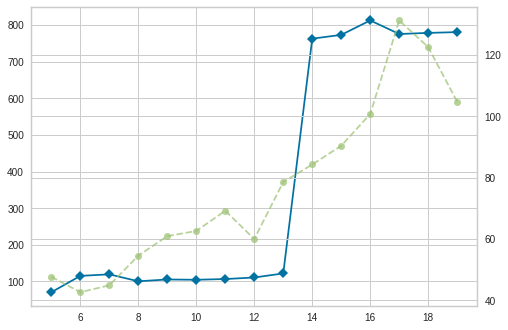

In [85]:
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,20))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [95]:
km = KMeans(n_clusters = 5)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
ind = km.labels_

In [0]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
Y_train = Y[ix_train]
Y_test = Y[ix_test]

In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train[:,:]).float()
Y_train = torch.tensor(Y_train[:,:]).float()
ind_train = torch.tensor(ind_train[:]).long()
n_ind = max(ind_train) + 1

In [0]:
def hierarchical_model(X, ind, n_ind, obs=None):
    input_dim = X.shape[1]
    n_cat = 24

    alpha_mu = pyro.sample("alpha_mu", dist.Normal(torch.zeros(n_cat), 10.*torch.ones(n_cat))) # Prior for the bias mean
    alpha_sigma = pyro.sample("alpha_sigma",  dist.HalfCauchy(10.*torch.ones(n_cat))) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 10.*torch.ones(input_dim, n_cat))) # Priors for the regression coefficents
    
    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event(1)) # Draw the individual parameter for each individual

    with pyro.plate("data", X.shape[0]):
        logits = alpha[ind] + X.matmul(beta)
        y = pyro.sample("y", dist.OneHotCategorical(logits=logits), obs=obs) # If you use logits you don't need to do sigmoid
        
    return y

In [100]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 1000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, ind_train, n_ind, Y_train)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 51556734.2
[100] ELBO: 40042020.4
[200] ELBO: 30202072.4
[300] ELBO: 22622902.3
[400] ELBO: 16744209.0
[500] ELBO: 12783776.1
[600] ELBO: 9890944.4
[700] ELBO: 7836864.6
[800] ELBO: 6378499.1
[900] ELBO: 5043834.3
CPU times: user 56min 58s, sys: 46.7 s, total: 57min 44s
Wall time: 30min 34s


In [0]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train, ind_train, n_ind, Y_train)

In [0]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [103]:
# make predictions for test set
Y_hat = alpha_hat[ind_test,:] + np.dot(X_test, beta_hat)

Y_hat_arg=np.argmax(Y_hat,axis=1)
Y_hat_pred=np.zeros((Y_hat.shape[0],Y_hat.shape[1]))
for i in range(Y_hat.shape[0]): 
    Y_hat_pred[i,Y_hat_arg[i]]=1

# evaluate prediction accuracy
print("Accuracy:",accuracy_full_line(Y_hat_pred, Y_test))

Accuracy: 0.48689334105225435


In [104]:
# make predictions for test set with codprov
Y_hat = alpha_hat[ind_test,:] + np.dot(X_test, beta_hat)

Y_hat_arg=np.argmax(Y_hat,axis=1)
Y_hat_pred=np.zeros((Y_hat.shape[0],Y_hat.shape[1]))
for i in range(Y_hat.shape[0]): 
    Y_hat_pred[i,Y_hat_arg[i]]=1

# evaluate prediction accuracy
print("Accuracy:",accuracy_full_line(Y_hat_pred, Y_test))

Accuracy: 0.48689334105225435


#Fourth model: add the product trends

The dataset contains information about the products previously bought by some customers. We can use this to observ which products are the most popular

In [0]:
products = train_df[y_variables]

popular_products_vector = np.zeros(products.shape[1])

for i, (name, values) in enumerate(products.iteritems()):
    for val in values:
      popular_products_vector[i] += val

popular_products_vector /= products.shape[0]

#normalization
popular_products_vector = (popular_products_vector-min(popular_products_vector)) / (max(popular_products_vector)-min(popular_products_vector))

(24,)


In [0]:
#Need to change this later, and to take into account all the features
X_cat = np.concatenate([pd.get_dummies(train_df[x]) for x in columns_cat], axis=1)
#We don't need the codpers to make predictions based on the profile
X_num = train_df[columns_num[:-1]]
X = np.concatenate([X_cat, X_num], axis=1)

# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [0]:
sexo = pd.get_dummies(train_df["sexo"])
stamp = sexo.values
ind = stamp[:,0]

In [0]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
Y_train = Y[ix_train]
Y_test = Y[ix_test]

In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train[:2000,:]).float()
Y_train = torch.tensor(Y_train[:2000,:]).float()
ind_train = torch.tensor(ind_train[:2000]).long()
n_ind = max(ind_train) + 1
popular_products_vector = torch.tensor(popular_products_vector).float()

In [0]:
def final_model(X, ind, n_ind, products, obs=None):
    input_dim = X.shape[1]
    n_cat = 24
    n_products = products.shape[0]

    alpha_mu = pyro.sample("alpha_mu", dist.Normal(torch.zeros(n_cat), 10.*torch.ones(n_cat))) # Prior for the bias mean
    alpha_sigma = pyro.sample("alpha_sigma",  dist.HalfCauchy(10.*torch.ones(n_cat))) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 10.*torch.ones(input_dim, n_cat))) # Priors for the regression coefficents
    beta_products = pyro.sample("beta_product", dist.Normal(torch.zeros(n_products, n_cat), 10.*torch.ones(n_products, n_cat)))

    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event(1)) # Draw the individual parameter for each individual

    with pyro.plate("data", X.shape[0]):
        logits = alpha[ind] + X.matmul(beta) + products.matmul(beta_products)
        y = pyro.sample("y", dist.OneHotCategorical(logits=logits), obs=obs) # If you use logits you don't need to do sigmoid
        
    return y

In [0]:
%%time
# Define guide function
guide = AutoDiagonalNormal(final_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 5000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(final_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, ind_train, n_ind, popular_products_vector, Y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 58155.7
[500] ELBO: 12784.4
[1000] ELBO: 5238.3
[1500] ELBO: 5080.0
[2000] ELBO: 4661.6
[2500] ELBO: 4657.8
[3000] ELBO: 4754.1
[3500] ELBO: 4614.3
[4000] ELBO: 4691.6
[4500] ELBO: 5258.6
CPU times: user 3min 49s, sys: 870 ms, total: 3min 50s
Wall time: 1min 17s


In [0]:
from pyro.infer import Predictive

predictive = Predictive(final_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma", "beta_product"))
samples = predictive(X_train, ind_train, n_ind, popular_products_vector, Y_train)

In [0]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()
beta_product_hat = samples["beta_product"].mean(axis=0).detach().numpy()

In [0]:
# make predictions for test set
Y_hat = alpha_hat[ind_test,:] + np.dot(X_test, beta_hat) + np.dot(popular_products_vector, beta_product_hat)

Y_hat_arg=np.argmax(Y_hat,axis=1)
Y_hat_pred=np.zeros((Y_hat.shape[0],Y_hat.shape[1]))
for i in range(Y_hat.shape[0]): 
    Y_hat_pred[i,Y_hat_arg[i]]=1

# evaluate prediction accuracy
print("Accuracy:",accuracy_full_line(Y_hat_pred, Y_test))

Accuracy: 0.410657736686929
